<a href="https://colab.research.google.com/github/martaherraiz/clase0/blob/main/Lab04GrupoA04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 04 Ordinaria

Grupo A04

Lucía Casas, Marta Herraiz, Alba López, Paula Redondo

## EJERCICIO 1

Una prestigiosa empresa productora de vinos quiere construir un modelo de regresión que le permita predecir el porcentaje de alcohol de un vino en base a ciertas características (acidez, azúcar residual, azufre, cloruros, densidad, tipo de vino, sulfatos y pH).

Para ello han construido un dataset, denominado wine_alcohol.csv, que contiene la información de todos los vinos que han sido producidos en los últimos años con el objetivo de construir un modelo y realizar las siguientes acciones:

In [1]:
# Librerías necesarias
from google.colab import files

import pandas as pd
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carga del archivo al directorio de trabajo
uploaded = files.upload()

Saving wine_alcohol.csv to wine_alcohol (1).csv


In [3]:
file_path = 'wine_alcohol.csv'

# Guarda el archivo csv en el DataFrame
df = pd.read_csv(file_path, sep=';')
# Visualización inicial
df.head()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,1,9.8
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4


**1) Realizar todo el proceso de preparación, limpieza y análisis de los datos con el objetivo de identificar aquellas variables candidatas para el proceso de regresión.**

In [4]:
# Obtener el número de filas en el DataFrame
num_filas_orig = len(df)

# Mostrar el resultado
print(f"Número de filas en el DataFrame: {num_filas_orig}")

Número de filas en el DataFrame: 6497


In [5]:
df = df.drop_duplicates()
num_dupl = num_filas_orig - len(df)

print(f'Se han eliminado {num_dupl} duplicados.\nNúmero de registros actualizado: {len(df)}')

Se han eliminado 0 duplicados.
Número de registros actualizado: 6497


In [6]:
# Calcula la cantidad de NaN en cada columna
nan_count = df.isna().sum()

# Imprime el resultado
print("NaN por columna:")
print(nan_count)

NaN por columna:
id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
quality                 0
wine type               0
alcohol                 0
dtype: int64


In [7]:
print(df.dtypes)

id                        int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
quality                   int64
wine type                 int64
alcohol                 float64
dtype: object


Parece que las columnas que se corresponden con la calidad y el tipo de vino toman valores categóricos. El resto de atributos son variables numéricas continuas.

Vamos a ver si hay valores negativos en alguna columna y si eso es viable.

In [8]:
valores_negativos = {}

for columna in df.columns:
    valores_negativos[columna] = df[df[columna] < 0].index.tolist()

print("Valores negativos por columna:")
for columna, indices in valores_negativos.items():
    if len(indices) > 0:
        print(f"Columna '{columna}': {indices}")
    else:
        print(f"Columna '{columna}': No hay valores negativos")

Valores negativos por columna:
Columna 'id': No hay valores negativos
Columna 'fixed acidity': No hay valores negativos
Columna 'volatile acidity': No hay valores negativos
Columna 'citric acid': No hay valores negativos
Columna 'residual sugar': No hay valores negativos
Columna 'chlorides': No hay valores negativos
Columna 'free sulfur dioxide': No hay valores negativos
Columna 'total sulfur dioxide': No hay valores negativos
Columna 'density': No hay valores negativos
Columna 'pH': No hay valores negativos
Columna 'sulphates': No hay valores negativos
Columna 'quality': No hay valores negativos
Columna 'wine type': No hay valores negativos
Columna 'alcohol': No hay valores negativos


No hay valores negativos en ninguna de las columnas luego OK

In [9]:
# Eliminar una columna por nombre
df = df.drop(columns='id')

Ahora vamos a ver cómo se distribuyen las variables y ver si hay outliers

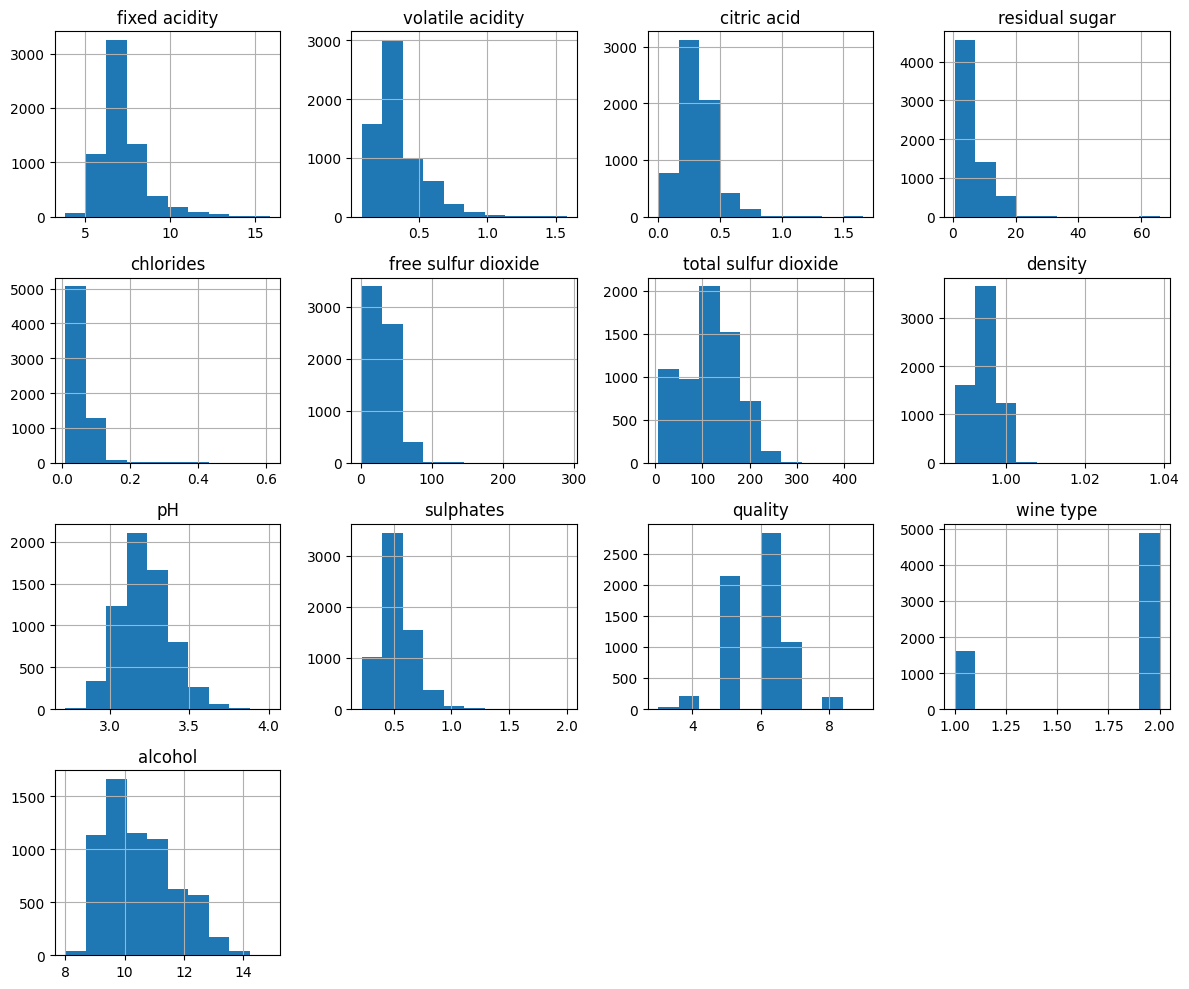

In [10]:
# Visualización de histogramas para cada atributo
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

Para el proceso de eliminar outliers, los mostraremos en un boxplot, y eliminaremos aquellos datos que visulamente estén muy separados del resto de datos. Pues como vamos a observar, es cierto que en algunas variables hay muchos outliers, pero que no hay apenas distancia entre ellos. Cuando se visualice un 'salto' entre outliers, pondremos una línea roja, lo que estén separados por esa línea roja serán eliminados.

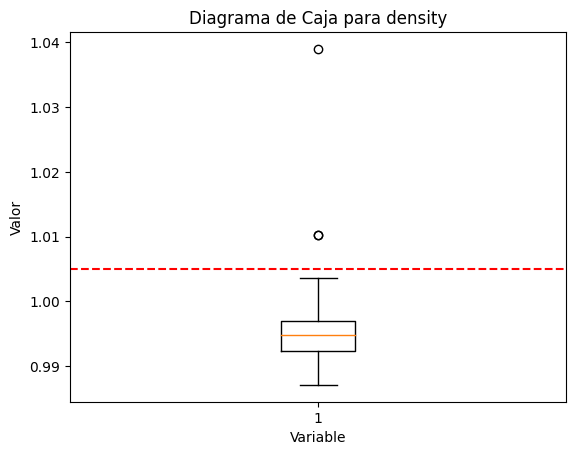

In [11]:
# Dibujar el boxplot
plt.boxplot(df['density'])
plt.axhline(y=1.005, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('density'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [12]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 1.005

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['density'] <= umbral]

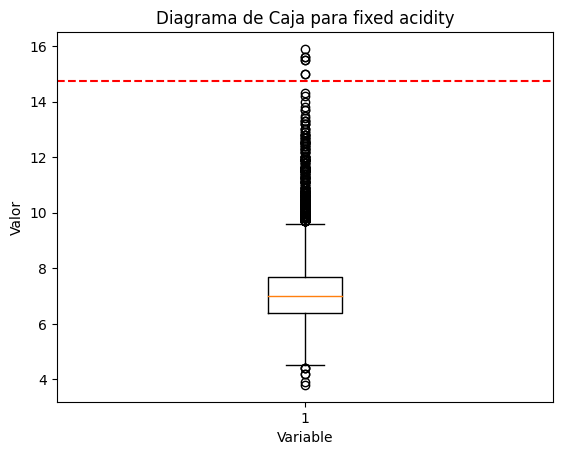

In [13]:
# Dibujar el boxplot
plt.boxplot(df['fixed acidity'])
plt.axhline(y=14.75, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('fixed acidity'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [14]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 14.75

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['fixed acidity'] <= umbral]

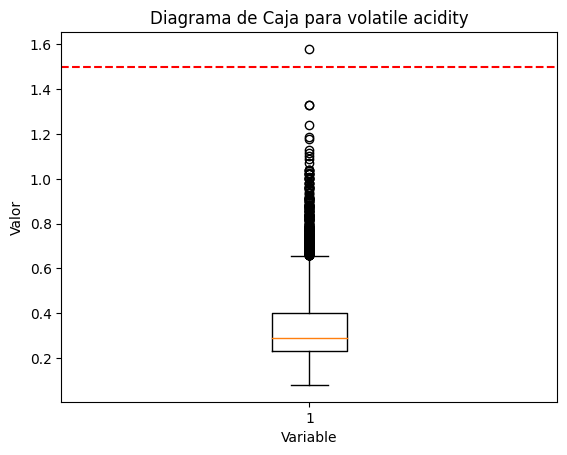

In [15]:
# Dibujar el boxplot
plt.boxplot(df['volatile acidity'])
plt.axhline(y=1.5, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('volatile acidity'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [16]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 1.5

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['volatile acidity'] <= umbral]

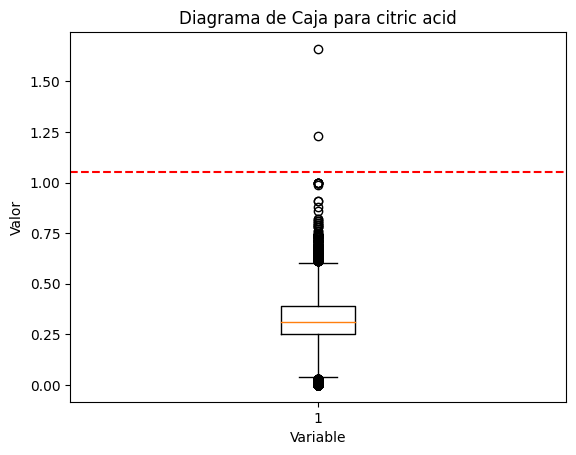

In [17]:
# Dibujar el boxplot
plt.boxplot(df['citric acid'])
plt.axhline(y=1.05, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('citric acid'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [18]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 1.05

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['citric acid'] <= umbral]

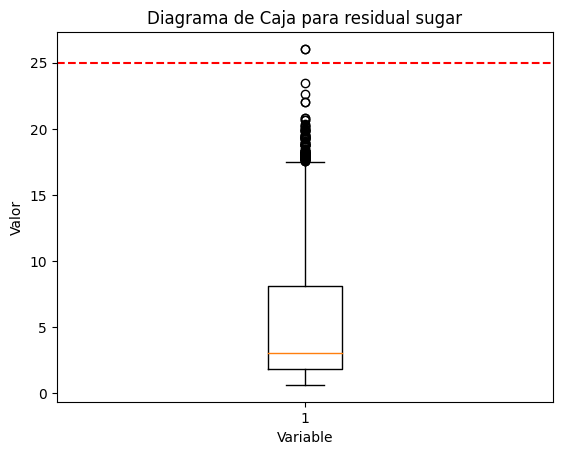

In [19]:
# Dibujar el boxplot
plt.boxplot(df['residual sugar'])
plt.axhline(y=25, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('residual sugar'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [20]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 25

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['residual sugar'] <= umbral]

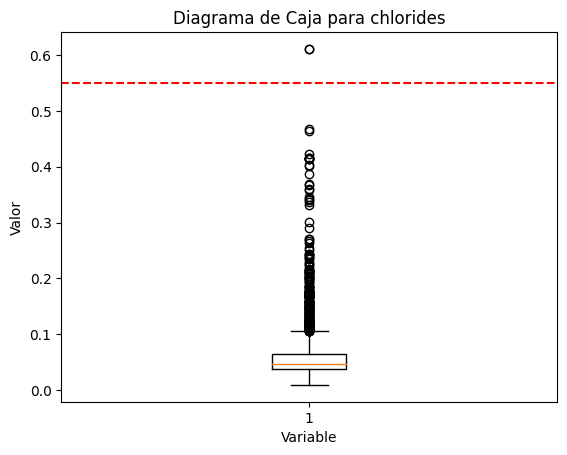

In [21]:
# Dibujar el boxplot
plt.boxplot(df['chlorides'])
plt.axhline(y=0.55, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('chlorides'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [22]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 0.55

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['chlorides'] <= umbral]

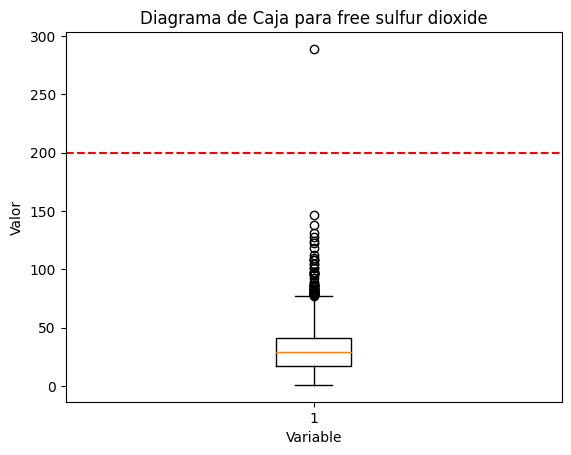

In [23]:
# Dibujar el boxplot
plt.boxplot(df['free sulfur dioxide'])
plt.axhline(y=200, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('free sulfur dioxide'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [24]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 200

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['free sulfur dioxide'] <= umbral]

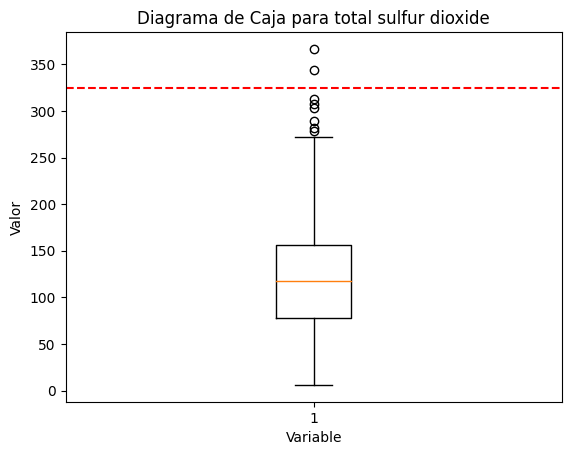

In [25]:
# Dibujar el boxplot
plt.boxplot(df['total sulfur dioxide'])
plt.axhline(y=325, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('total sulfur dioxide'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [26]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 325

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['total sulfur dioxide'] <= umbral]

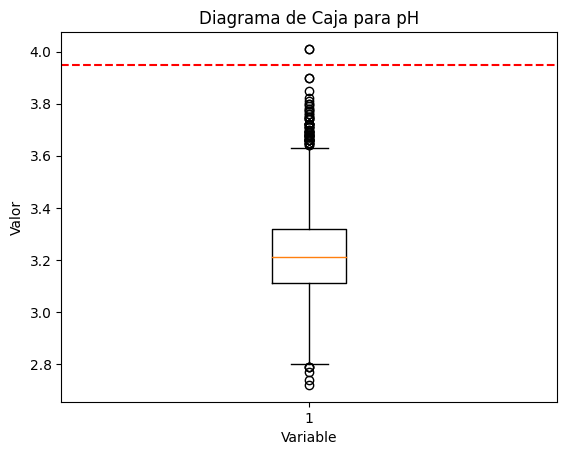

In [27]:
# Dibujar el boxplot
plt.boxplot(df['pH'])
plt.axhline(y=3.95, color='r', linestyle='--', label='Valor determinado') # Muy ajustado, no lo quitaría

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('pH'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [28]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 3.95

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['pH'] <= umbral]

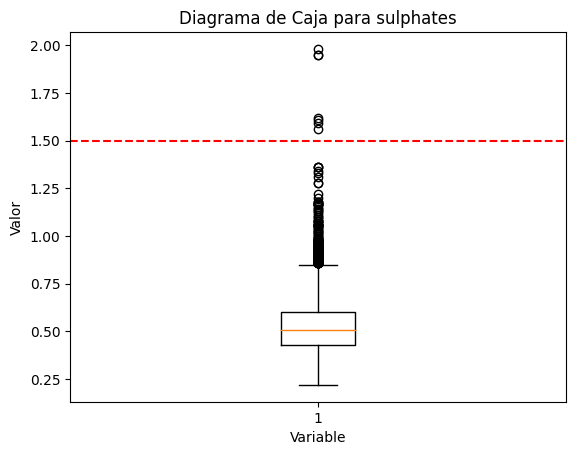

In [29]:
# Dibujar el boxplot
plt.boxplot(df['sulphates'])
plt.axhline(y=1.5, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('sulphates'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

In [30]:
# Suponiendo que 'data' es tu DataFrame y 'density' es la columna que deseas modificar
umbral = 1.5

# Filtrar las observaciones que no son outliers en la columna 'density'
df = df[df['sulphates'] <= umbral]

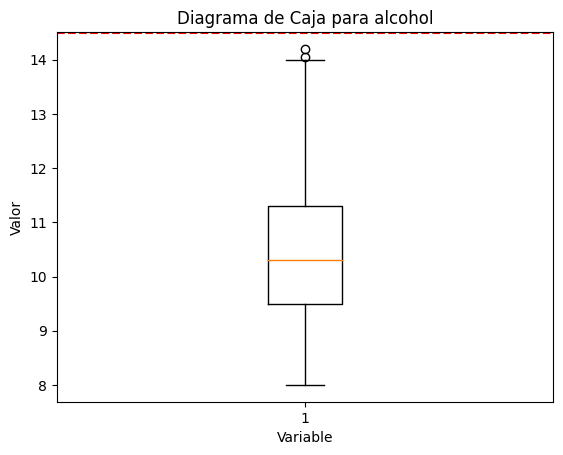

In [31]:
# Dibujar el boxplot
plt.boxplot(df['alcohol'])
plt.axhline(y=14.5, color='r', linestyle='--', label='Valor determinado')

# Agregar título y etiquetas
plt.title('Diagrama de Caja para {}'.format('alcohol'))
plt.xlabel('Variable')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

Ya daríamos por terminada la limpieza, después de haber comprobado que no hay elementos duplicados ni nans, y habernos deshecho de los outliers.

**2) Realizar un análisis sobre los atributos del dataset con el objetivo de entender las posibles relaciones que existen entre ellas y a continuación elige los dos atributos que mayor relación guardan con el atributo objetivo (nivel de alcohol). En necesario justificar la elección de los atributos mediante la utilización de datos empíricos.**

Volvamos a mirar ahora cómo se distribuyen los datos después de haber realizado la limpieza.

In [32]:
# Visualización de estadísticas descriptivas
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6468.000000       6468.000000  6468.000000     6468.000000   
mean        7.204971          0.338840     0.318007        5.427559   
std         1.268916          0.163515     0.143420        4.667155   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        14.300000          1.330000     1.000000       23.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6468.000000          6468.000000           6468.000000  6468.000000   
mean      0.055708            30.524119            115.727891     0.994673   
std       0.033262            17.465893             56.165683     0.002925   
min       0.009000             1.000000         

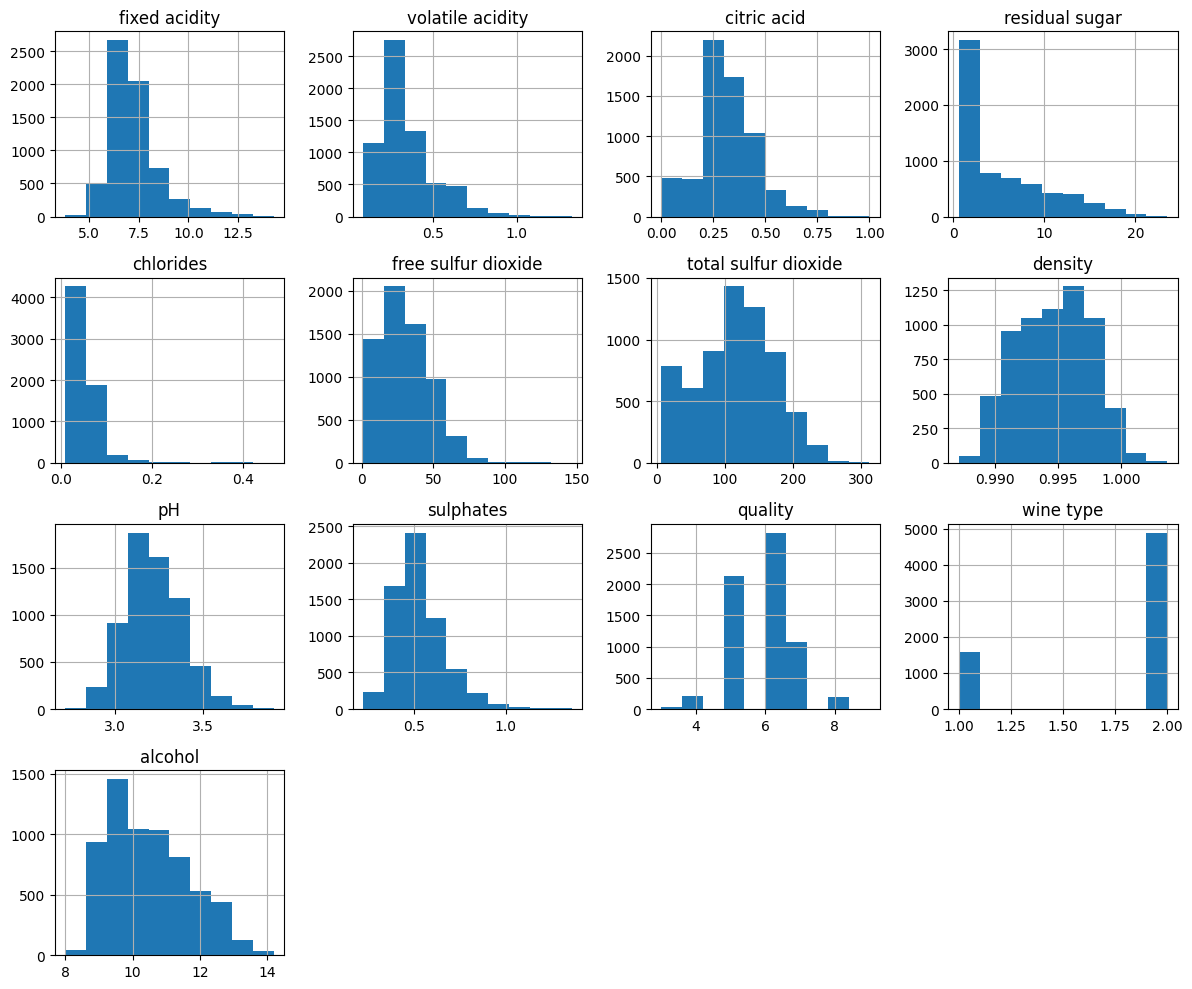

In [33]:
# Visualización de histogramas para cada atributo
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

Explicación y distribución de las variables:

* *fixed acidity:* La cantidad de ácidos no volátiles en el vino, principalmente ácido tartárico. Los datos muestran que la media de la acidez fija es de alrededor de 7.20 g/L, con un rango desde 3.80 g/L hasta 14.30 g/L.

* *volatile acidity:* La cantidad de ácidos volátiles en el vino, principalmente ácido acético. Los datos muestran que la media de la acidez volátil es de aproximadamente 0.34 g/L, con un rango desde 0.08 g/L hasta 1.33 g/L.

* *citric acid:* La cantidad de ácido cítrico presente en el vino. Los datos muestran que la media de ácido cítrico es de alrededor de 0.32 g/L, con un rango desde 0 g/L hasta 1 g/L.

* *residual sugar:* La cantidad de azúcar que permanece en el vino después de la fermentación. Los datos muestran que la media de azúcar residual es de aproximadamente 5.43 g/L, con un rango desde 0.6 g/L hasta 23.5 g/L.

* *chlorides:* La concentración de cloruros en el vino. Los datos muestran que la media de cloruros es de aproximadamente 0.056 g/L, con un rango desde 0.009 g/L hasta 0.467 g/L.

* *free sulfur dioxide:* La cantidad de dióxido de azufre que está libre en el vino. Los datos muestran que la media de dióxido de azufre libre es de alrededor de 30.52 mg/L, con un rango desde 1 mg/L hasta 146.5 mg/L.

* *total sulfur dioxide:* La suma de dióxido de azufre libre y dióxido de azufre combinado con otras moléculas en el vino. Los datos muestran que la media de dióxido de azufre total es de aproximadamente 115.73 mg/L, con un rango desde 6 mg/L hasta 313 mg/L.

* *density:* La densidad del vino. Los datos muestran que la media de densidad es de aproximadamente 0.9947 g/cm³, con un rango desde 0.9871 g/cm³ hasta 1.0037 g/cm³.

* pH: La medida de acidez o alcalinidad del vino en una escala de 0 a 14, donde 7 es neutro. Los datos muestran que la media del pH es de aproximadamente 3.22, con un rango desde 2.72 hasta 3.90.

* sulphates: La cantidad de sulfatos presentes en el vino. Los datos muestran que la media de sulfatos es de alrededor de 0.53 g/L, con un rango desde 0.22 g/L hasta 1.36 g/L.

* quality: Una medida subjetiva de la calidad del vino, a menudo asignada por catadores expertos o mediante análisis sensoriales. Variable categórica que toma valores desde el 3 hasta el 9.

* wine type: La categorización del vino según su tipo. Variable categórica que toma valores de 1 o 2 en base al tipo de vino.

* alcohol: El contenido de alcohol en el vino, generalmente expresado como porcentaje de volumen. Los datos muestran que la media del contenido de alcohol es de aproximadamente 10.49%, con un rango desde 8% hasta 14.2%.

Veamos como se relacionan las variables entre sí, para eso utilizaremos la matriz de correlaciones.

La matriz de correlación es una herramienta fundamental en estadística para entender las relaciones entre las variables en un conjunto de datos. Se utiliza para calcular y mostrar cómo las variables están relacionadas entre sí.

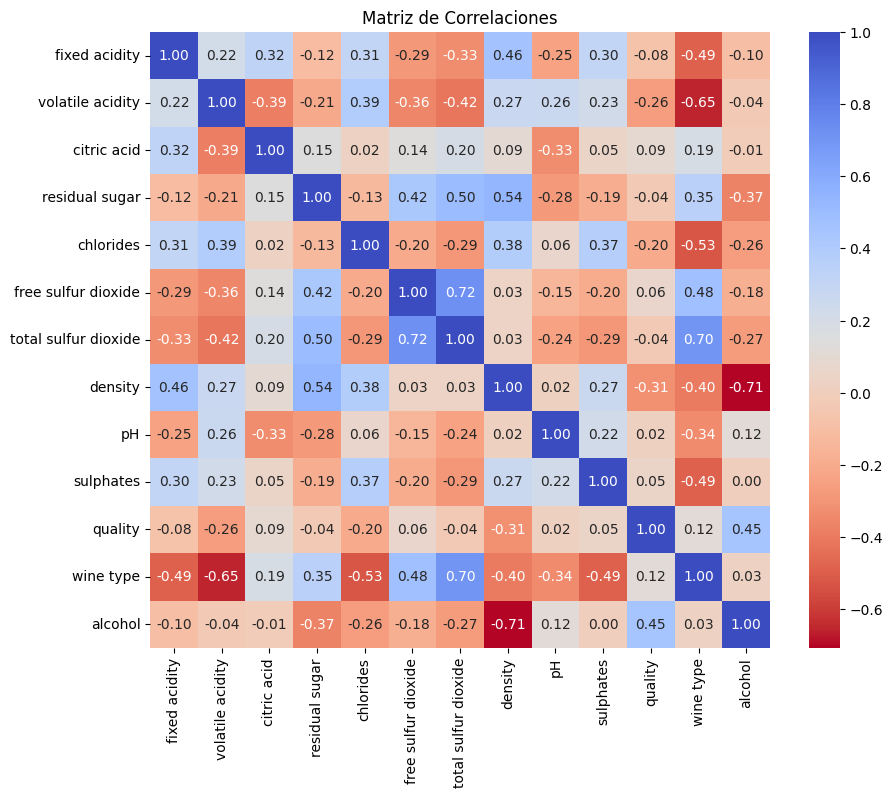

In [34]:
# Calcular la matriz de correlaciones
matriz_correlaciones = df.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Dibujar la matriz de correlaciones utilizando seaborn
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm_r', fmt=".2f")

# Añadir título
plt.title('Matriz de Correlaciones')

# Mostrar el gráfico
plt.show()

Podemos ver que la variable que más relación positiva tiene con respecto al nivel de alcohol (`alcohol`), es la de la calidad del vino (`quality`), dado que tienen un coeficiente de correlación del 0.45, esta sería una relación directa. *En este caso, no nos interesa tomar esta variable para el estudio de regresión pues es una variable categórica?*

Por otro lado, vemos que la relación que existe entre el nivel de alcohol (`alcohol`) y la densidad (`density`), es de manera inversa, con un coeficiente de correlación de -0.71.

**3) Construir un modelo de regresión lineal mediante un proceso analítico para una de las variables seleccionadas en el punto anterior.**

Seleccionamos la variable independiente, en este caso `density`, pues es la que mayor coeficiente de autocorrelación tiene con la variable dependiente en valor absoluto. La variable dependiente u objetivo, que como marca en enunciado, es `alcohol`

In [35]:
X = df[['density']]
y = df['alcohol']

Dividiremos el conjunto de datos en entrenamiento y test, para entrenar el modelo con una parte de los datos y evaluar su rendimiento con la otra parte.

Los dividiremos de manera aleatoria de forma que en el conjunto de entrenamiento esté el 70% de los datos y en el de test el 30% restante.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Creamos y entrenamos nuestro modelo de regresión lineal.

In [37]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

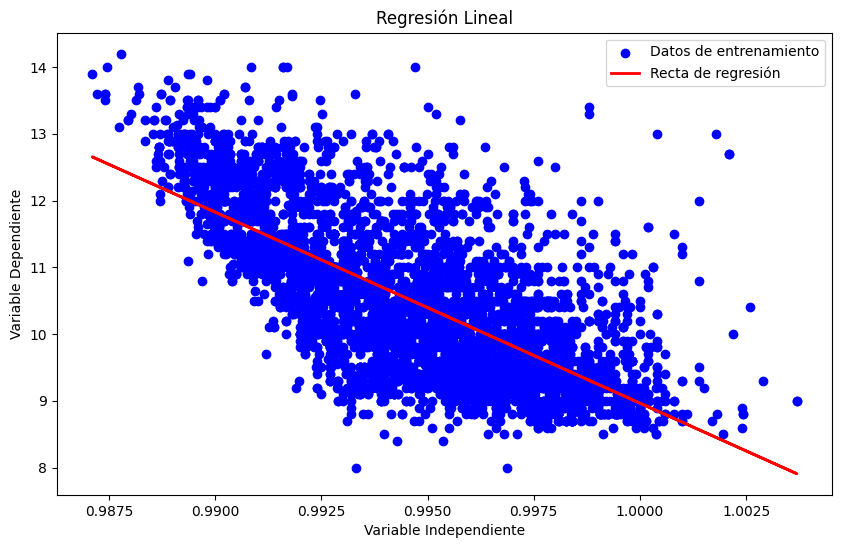

In [38]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred_train = modelo.predict(X_train)

# Crear la figura y el lienzo
plt.figure(figsize=(10, 6))

# Dibujar los puntos de datos de entrenamiento
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')

# Dibujar la recta de regresión
plt.plot(X_train, y_pred_train, color='red', linewidth=2, label='Recta de regresión')

# Añadir etiquetas y título
plt.xlabel('Variable Independiente')
plt.ylabel('Variable Dependiente')
plt.title('Regresión Lineal')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

Realizar predicciones en el conjunto de prueba:

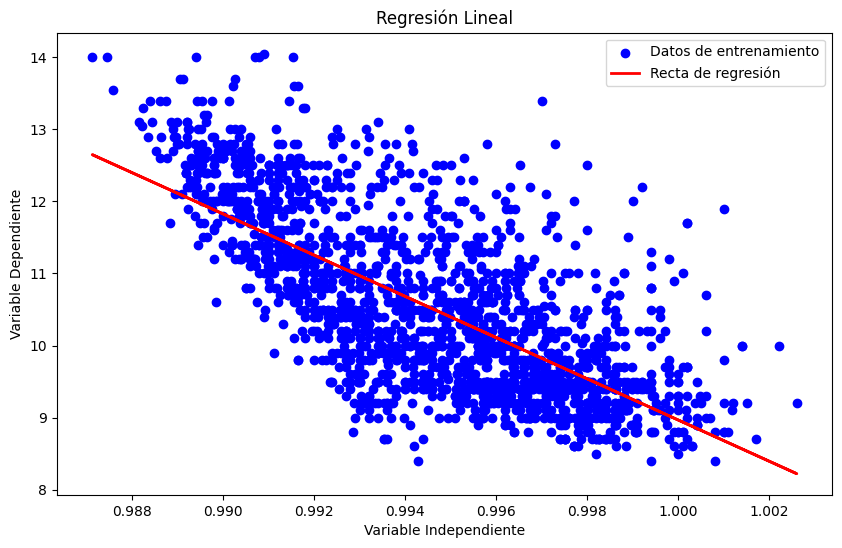

In [39]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred = modelo.predict(X_test)

# Crear la figura y el lienzo
plt.figure(figsize=(10, 6))

# Dibujar los puntos de datos de entrenamiento
plt.scatter(X_test, y_test, color='blue', label='Datos de entrenamiento')

# Dibujar la recta de regresión
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Recta de regresión')

# Añadir etiquetas y título
plt.xlabel('Variable Independiente')
plt.ylabel('Variable Dependiente')
plt.title('Regresión Lineal')

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

**4) Calcular el error en el modelo obtenidos en el punto anterior**

In [40]:
# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el Coeficiente de Determinación (R^2)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio: 0.7043520984153921
Coeficiente de determinación (R^2): 0.5133932339936331


El Error Cuadrático Medio (ECM) y el Coeficiente de Determinación ($R^2$) son medidas comunes utilizadas para evaluar la calidad de un modelo de regresión.

Error Cuadrático Medio (ECM): Esta es una medida de la precisión de las predicciones de un modelo de regresión. Un ECM más bajo indica un mejor ajuste del modelo a los datos. En nuestro caso, el ECM es de 0.704, lo que significa que, en promedio, las predicciones del modelo se desvían de los valores reales por aproximadamente 0.704 unidades al cuadrado.

Coeficiente de Determinación ($R^2$): Este valor indica la proporción de la variabilidad en la variable dependiente que es explicada por el modelo de regresión. Un $R^2$ más alto indica un mejor ajuste del modelo a los datos. En nuestro caso, el $R^2$ es de aproximadamente 0.513, lo que significa que alrededor del 51.3% de la variabilidad en la variable dependiente es explicada por el modelo de regresión lineal simple.

Estos resultados indican que el modelo de regresión lineal simple tiene un ajuste moderado a los datos. Aunque explica algo de la variabilidad en la variable dependiente, aún queda una cantidad significativa de variabilidad que no está siendo explicada por el modelo. Esto podría indicar que se necesitan otros predictores o que la relación entre la variable independiente y la variable dependiente no es completamente lineal.

## Ejercicio 2

La empresa productora de vinos cree que es posible construir un modelo de mejor calidad que pueda predecir mejor el grado de alcohol de los futuros vinos si se utilizan varios atributos del dataset. Para ello se solicita la creación de nuevos modelos realizando las siguientes acciones:

1. Crear los diferentes conjuntos de entrenamiento y test para el dataset (0.25 puntos).

Antes de proceder con la división de los registros presentes, es necesario modificar el formato de los valores del DataFrame para adecuarlo a la tarea de regresión con el fin de facilitar el procesado de información. De acuerdo a los histogramas observado previamente, dos de las variables del set de datos son de tipo categórico, mientras que las restante toman valores numéricos. Por lo tanto, se codifica como One Hot la información contenida en estas dos primeras características mencionadas. Además, se normalizarán las varibles continuas para obtener un DataFrame en el que todos los atributos tomen valores en el mismo rango.

In [41]:
categorical_features = ['wine type', 'quality']
numeric_features = list(set(df.columns) - set(categorical_features))

# Definimos el preprocesamiento utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalizamos las variables numéricas
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Se crea un Pipeline con el preprocesamiento y se aplica sobre el DataFrame
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
transformed_data = pipeline.fit_transform(df)

# Nombres de las características tras OneHotEncoder
encoded_categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']\
                                .get_feature_names_out(input_features=categorical_features)

# Combinamos los nombres de las características numéricas y categóricas
feature_names = numeric_features + list(encoded_categorical_features)

# Creación de un nuevo DataFrame con el resultado
normalized_df = pd.DataFrame(transformed_data, columns=feature_names)


La base de datos original se compone de 6497 registros de información, los cuales se han reducido a 6468 tras la limpieza de datos. Para la tarea de regresión, es necesario dividir los datos disponibles en tres conjuntos diferentes:
* Conjunto de entrenamiento
* Conjunto de validación
* Conjunto de test

En este caso, se reservan alrededor de un 20% de los registros disponibles como conjunto de test, sobre los cuales se probará el modelo de regresión final. El resto de registro se emplearán para el entrenamiento de dicho modelo. No obstante, es necesario definir un conjunto de validación que permita evaluar la precisión de los modelos que se construyan durante la definición de los clasificadores. Para ello, del 80% restante de filas, un 15% de estas se asignarán como conjunto de validación.

En resumen, el 68% del DataSet estará enfocado al entrenamiento, un 12% se utilizará para la validación, y el último 20% será el conjunto de test.

In [42]:
# Definir los atributos y la variable objetivo
variable_objetivo = 'alcohol'
atributos = normalized_df.columns.tolist()
atributos.remove(variable_objetivo)

# Dividir el dataset en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_def, X_test, y_train_def, y_test = train_test_split(normalized_df[atributos], normalized_df[variable_objetivo], test_size=0.2, random_state=42)

# Luego, dividimos el conjunto de entrenamiento nuevamente para obtener un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_def, y_train_def, test_size=0.15, random_state=42)

# Tamaño de los conjuntos
print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de validación:", X_val.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])


Tamaño del conjunto de entrenamiento: 4397
Tamaño del conjunto de validación: 777
Tamaño del conjunto de prueba: 1294


2. Construir un modelo de regresión que utilice al menos 4 de los atributos (es posible utilizar más atributos) disponibles en el dataset mediante la utilización de un proceso aprendizaje iterativo. (1.5 puntos).

Para construir el modelo que muestre el comportamiento más óptimo en la predicción del valor objetivo, es necesario definir una métrica de evaluación de su rendimiento. En este caso, por tratarse de un problema de regresión múltiple, se definirá el error cuadrático medio (MSE) como medida de eficiencia para cada uno de los modelos.

Como se ha comentado anteriormente, el propósito del ejercicio se centra en localizar el conjunto de atributos que logre predecir con mayor precisión el porcentaje de alcohol de los diferentes vinos que produce la empresa. Para ello, se hallarán todas las posibles combinaciones de cuatro y cinco elementos escogidos de entre todos los atributos explicativos de la base de datos. Cada una de estas combinaciones será evaluada siguiendo el criterio especificado. Aquel conjunto que muestre el menor error cuadrático medio se considerará como mejor candidato para nuestro modelo de reresión final.

In [43]:
# Definimos una función para evaluar el rendimiento del modelo con diferentes conjuntos de características
def evaluate_features(features_subset):

    # Inicializamos y entrenamos el modelo de regresión lineal múltiple
    model = LinearRegression()
    model.fit(X_train[features_subset], y_train)

    # Realizamos predicciones en el conjunto de prueba
    y_pred = model.predict(X_val[features_subset])

    # Calculamos el error cuadrático medio (MSE) en el conjunto de prueba
    mse = mean_squared_error(y_val, y_pred)

    return mse


In [44]:
# Combinaciones de cuatro atributos
feature_combinations = list(itertools.combinations(sorted(atributos), 4))
feature_combinations = [list(i) for i in feature_combinations]

# Evaluamos el rendimiento del modelo para cada combinación de características
results = {}
for i, combination in enumerate(feature_combinations):
    mse = evaluate_features(combination)
    results[f'Combination {i+1}'] = mse

# DataFrame con los resultados
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean Squared Error'])
print(results_df)

                  Mean Squared Error
Combination 1               0.430330
Combination 2               0.472669
Combination 3               0.480242
Combination 4               0.512694
Combination 5               0.510475
...                              ...
Combination 3872            0.804157
Combination 3873            0.804157
Combination 3874            0.803262
Combination 3875            0.991592
Combination 3876            0.805149

[3876 rows x 1 columns]


In [45]:
results_df_sorted = results_df.sort_values(by='Mean Squared Error')
top_three_combinations = results_df_sorted.head(3)

print("Los tres con el menor MSE son:")
print(top_three_combinations)

Los tres con el menor MSE son:
                  Mean Squared Error
Combination 1518            0.258800
Combination 1591            0.284423
Combination 1590            0.284423


In [46]:
print(feature_combinations[1517])

['density', 'fixed acidity', 'pH', 'residual sugar']


In [47]:
# Inicializar un modelo de regresión lineal vacío
modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train[feature_combinations[1517]], y_train)
y_val_pred = modelo_regresion.predict(X_val[feature_combinations[1517]])

r2 = r2_score(y_val, y_val_pred)
print(r2)

0.7393408068465943


La combinación con la posición 1627 en la lista de resultados ha mostrado el menor MSE, con un valor de ```0.2588```. De acuerdo a su descripción, los atributos que mejor se comportan en la predicción del nivel de alcohol del vino incluyen:
* Densidad
* Acidez fija
* pH
* Azúcar residual

Asimismo, se recurre al cálculo del coeficiente de determinación para confirmar la eficiencia del modelo, pues este mide que cambios los atributos predictores están a su vez relacionados con la variable objetivo. Así, cuanto más cerca se encuentre de 1, mayor será la asociación positiva. El valor del coeficiente R2 obtenido a partir de las predicciones sobre el conjunto de validación es de ```0.7393```, el cual se encuentra bastante próximo a 1. Por lo tanto se podría considerar una opción viable. No obstante, se continuará con la evaluación de las combinaciones de cinco características.

In [48]:
# Combinaciones de cinco atributos
feature_combinations = list(itertools.combinations(sorted(atributos), 5))
feature_combinations = [list(i) for i in feature_combinations]

# Evaluamos el rendimiento del modelo para cada combinación de características
results = {}
for i, combination in enumerate(feature_combinations):
    mse = evaluate_features(combination)
    results[f'Combination {i+1}'] = mse

# DataFrame con los resultados
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean Squared Error'])
print(results_df)

                   Mean Squared Error
Combination 1                0.420482
Combination 2                0.364748
Combination 3                0.431263
Combination 4                0.429757
Combination 5                0.397435
...                               ...
Combination 11624            0.728390
Combination 11625            0.727113
Combination 11626            0.811389
Combination 11627            0.728378
Combination 11628            0.804157

[11628 rows x 1 columns]


In [49]:
results_df_sorted = results_df.sort_values(by='Mean Squared Error')
top_three_combinations = results_df_sorted.head(3)

print("Los tres con el menor MSE son:")
print(top_three_combinations)

Los tres con el menor MSE son:
                  Mean Squared Error
Combination 5598            0.174470
Combination 5599            0.174470
Combination 5596            0.220208


In [50]:
combination_def = feature_combinations[5597]
print(combination_def)

['density', 'fixed acidity', 'pH', 'residual sugar', 'wine type_1']


In [51]:
# Inicializar un modelo de regresión lineal vacío
modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train[combination_def], y_train)
y_val_pred = modelo_regresion.predict(X_val[combination_def])

r2 = r2_score(y_val, y_val_pred)
print(r2)

0.8242762556071678


Se observa que el menor error cuadrático obtenido es de ```0.1744```, con un descenso de más de 8 centésimas en comparación con la mejor combinación de cuatro atributos. Además, el coeficiente de determinación ha incrementado hasta alcanzar un ```0.8242```. Luego se considera este último grupo de atributos como los más adecuados para predecir el porcentaje de alcohol. En concreto, se trabajará con las mismas cuatro características que se han obtenido en la prueba anterior, incluyendo asimismo el clasificador que determina si un vino es de tipo 1 o no.

3. Calcular el error del modelo (0.5 puntos).

El error del modelo se halla mediante el cálculo del error cuadrático medio. De acuerdo al propio nombre, esta métrica calcula el promedio de las diferencias al cuadrado entre los valores predichos y los observados.

In [52]:
modelo_regresion = LinearRegression()

# Entrenar el modelo de regresión con todos los atributos seleccionados
modelo_regresion.fit(X_train[combination_def], y_train)

# Realizar predicciones en el conjunto de prueba
y_val_pred = modelo_regresion.predict(X_val[combination_def])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_val, y_val_pred)
print("Error cuadrático medio (MSE) del modelo:", mse)


Error cuadrático medio (MSE) del modelo: 0.17447017272388268


4. Evaluar el modelo anterior con el conjunto de test construido anteriormente y explicar el resultado obtenido. (0.25 puntos).

In [53]:
modelo_regresion = LinearRegression()

# Entrenar el modelo de regresión con todos los atributos seleccionados
modelo_regresion.fit(X_train_def[combination_def], y_train_def)

# Realizar predicciones en el conjunto de prueba
y_test_pred = modelo_regresion.predict(X_test[combination_def])

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_test_pred)
print("Error cuadrático medio (MSE) del modelo:", mse)

r2 = r2_score(y_test, y_test_pred)
print("Coeficiente de determinación:", r2)

Error cuadrático medio (MSE) del modelo: 0.16903838079629124
Coeficiente de determinación: 0.8330248486082615


Una vez se entrena el modelo final tanto con el conjunto de entrenamiento como con el conjunto de validación, se logra un mayor nivel de información, favoreciendo la capacidad de predicción de nuestro modelo de regresión. Así, el error cuadrático medio que resulta de su evaluación sobre el conjunto de test muestra un valor ligeramente menor al hallado previamente, con un ```0.1690```. Además, también se observa un incremento en el coeficiente de determinación, cuyo valor asciende ahora al ```0.8330```.

5. Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de confianza del 75% y explica el resultado obtenido (0.5 puntos).

Los intervalos de confianza proporcionan una medida de la incertidumbre alrededor de los coeficientes estimados del modelo de regresión múltiple. Cuanto más pequeño sea el intervalo, mayor será la precisión de la estimación del coeficiente.

Para obtener estos valores, se recurre a la librería de Python ***statsmodels***, que calculará los intervalos de confianza para la regresión de acuerdo a la técnica de mínimos cuadrados ordinarios (*Ordinary Least Squared*). De acuerdo a las especificaciones del enunciado, se establece el nivel de significación a ```0.25```.

In [54]:
# Añadir una columna de intercepto al conjunto de entrenamiento
X_train_intercepto = sm.add_constant(X_train_def[combination_def])

# Construir y entrenar el modelo usando statsmodels
modelo_stats = sm.OLS(y_train_def, X_train_intercepto).fit()

# Obtener los intervalos de confianza para los coeficientes
intervalos_confianza = modelo_stats.conf_int(alpha=0.25)
print("Intervalos de confianza para los coeficientes de regresión:")
print(intervalos_confianza)


Intervalos de confianza para los coeficientes de regresión:
                       0         1
const          -0.319945 -0.302380
density        -1.733832 -1.706949
fixed acidity   0.619850  0.639808
pH              0.370225  0.386890
residual sugar  0.911836  0.937009
wine type_1     1.247614  1.296886


A partir de los resultados obtenidos, se pueden trazar la dirección que cada uno de los atributos encargados de explicar la regresión guardan con la variable objetivo, es decir, su influencia en el nivel de alcohol del vino. Se aprecia que la variable referida a la densidad está definida por un coeficiente negativo en la regresión, indicando la relación inversa que mantiene con la variable de estudio. Así, cuanto mayor sea la densidad del vino, menor será su porcentaje de alcohol. Además, aquellos vinos clasificados como tipo 1 tienen niveles de alcohol menores que el resto. Asimismo, se aprecia que, de entre los distintos atributos que guardan una relación porporcional con la cantidad de alcohol, el azúcar residual muestra una relación más fuerte. Es decir, aquellos vinos más dulces se caracterizarán por un contenido de alcohol mayor.

## Ejercicio 3

In [55]:
datos = df.copy()

Ya se verificó antes que no hay valores faltantes en el conjunto de datos. También se realizó un análisis exploratorio para comprender la distribución de cada una de las variables y se pintó la matriz de correlaciones para entender las relaciones entre ellas.

Dado que el objetivo principal es comprobar si los vinos se agrupan de manera similar a como han sido valorados por la empresa evaluadora (quality), el enfoque más adecuado para la selección de características sería elegir las variables en base a su correlación con la variable 'quality'.

Razones para elegir este enfoque:

1. **Relevancia directa:** La calidad del vino es la variable objetivo que queremos analizar en relación con los grupos que se forman. Por lo tanto, tiene sentido seleccionar características que estén más correlacionadas con esta variable para capturar mejor las diferencias en la calidad del vino entre los grupos.

2. **Interpretación más clara:** Al elegir características que están altamente correlacionadas con la calidad del vino, podemos interpretar más fácilmente cómo estas características influyen en la evaluación de la calidad. Esto puede proporcionar insights más útiles sobre las características que realmente importan para la calidad del vino y cómo se relacionan con los grupos identificados por el algoritmo de agrupamiento.

3. **Enfoque centrado en el objetivo:** Al centrarnos en la variable objetivo, estamos alineando nuestro proceso de selección de características con el objetivo principal del análisis, que es comprender cómo la calidad del vino está relacionada con los grupos identificados.



In [56]:
# Calcular la correlación de cada característica con 'quality'
quality_correlation = datos.corr()['quality'].abs().sort_values(ascending=False)

# Excluir la variable 'quality' del conjunto de características seleccionadas
significant_features = quality_correlation[quality_correlation.index != 'quality']

# Seleccionar las características con una correlación significativa (por ejemplo, mayor que 0.3)
significant_features = significant_features[significant_features > 0.2].index.tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas basadas en su correlación con 'quality': ")
print(significant_features)


Características seleccionadas basadas en su correlación con 'quality': 
['alcohol', 'density', 'volatile acidity', 'chlorides']


Vemos que en general, las variables no están muy correlacionadas entre sí y las que más correlación tienen con la calidad son el alcohol, la densidad, la acidez volátil y los clorulos.

Otra opción para elegir las variables candidatas para hacer clustering es utilizando Random Forest para la selección de características, principalmente porque nos permite identificar las características más influyentes en la clasificación de la variable objetivo, en este caso, "quality". Random Forest ofrece varias ventajas que respaldan esta elección:

1. **Identificación de características relevantes**: Al evaluar la importancia de las características en el proceso de clasificación, Random Forest puede distinguir qué variables tienen un impacto significativo en la predicción de la calidad del vino. Esto nos permite centrarnos en aquellas características que son más relevantes para la tarea de clasificación.

2. **Manejo de relaciones no lineales y no monótonas**: Random Forest es capaz de capturar relaciones no lineales y no monótonas entre las características y la variable objetivo. Esto es especialmente beneficioso en un contexto donde la relación entre las características y la calidad del vino puede ser compleja y no lineal.

3. **Robustez frente al sobreajuste**: Random Forest tiende a generalizar bien a datos no vistos y es menos propenso al sobreajuste en comparación con otros modelos más complejos. Esto asegura que la selección de características esté fundamentada en la capacidad de generalización del modelo, lo que es crucial para garantizar la relevancia de las características seleccionadas en diferentes conjuntos de datos.

4. **Eficiencia computacional**: Aunque Random Forest es un algoritmo de aprendizaje automático poderoso, es relativamente eficiente en términos de tiempo de entrenamiento y recursos computacionales requeridos. Esto permite realizar la selección de características de manera rápida y escalable, incluso en conjuntos de datos grandes.

Al utilizar Random Forest para la selección de características, podemos identificar un subconjunto óptimo de variables que maximicen la capacidad del modelo para clasificar adecuadamente la calidad del producto. Esto nos permite centrar nuestros esfuerzos en las características más relevantes y potencialmente mejorar el rendimiento del clustering al considerar únicamente aquellas variables que tienen un impacto significativo en la clasificación de la calidad del producto.

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd

# Crear un modelo de clasificación (por ejemplo, Random Forest)
clf = RandomForestClassifier()

# Entrenar el modelo de clasificación con tus datos y la variable objetivo
X = datos.drop('quality', axis=1)  # Elimina la variable objetivo
y = datos['quality']  # Variable objetivo
clf.fit(X, y)

# Especificar un umbral más alto para la importancia de las características
umbral_importancia = 0.09

# Seleccionar características basadas en la importancia del modelo de clasificación
selector = SelectFromModel(clf, threshold=umbral_importancia, prefit=True)

# Obtener las características seleccionadas
selected_features = X.columns[selector.get_support()]

# Mostrar las características seleccionadas
print("Variables seleccionadas para hacer clustering:")
print(selected_features)



Variables seleccionadas para hacer clustering:
Index(['volatile acidity', 'total sulfur dioxide', 'density', 'alcohol'], dtype='object')


Podemos observar que 3 de las 4 variables seleccionadas mediante este método coinciden con las elegidas en el método anterior. La cantidad de variables seleccionadas variará en función de los umbrales establecidos, pero es notable que, en términos generales, para las características más representativas, hay una coincidencia entre ambos métodos.

Para determinar el valor óptimo de 𝑘 en el algoritmo K-Means, se puede utilizar el método del codo (Elbow Method) y la silueta (Silhouette Method), ambos basados en medidas empíricas de la calidad de la agrupación.

**Método del Codo (Elbow Method):**

Se ejecuta el algoritmo K-Means con diferentes valores de
𝑘, por ejemplo vamos a probar desde 1 hasta 10. Después, se
calcula la suma de los cuadrados de las distancias de cada punto al centroide más cercano para cada valor de 𝑘. Esta medida se conoce como la inercia del clúster. Por último se grafica la inercia para cada valor de 𝑘.

Observando el gráfico se debe buscar el punto donde la disminución de la inercia se estabiliza. Este punto es conocido como el "codo". Se selecciona el valor de 𝑘 correspondiente al codo como el número óptimo de clústeres.

**Método de la Silueta (Silhouette Method):**

Se ejecuta el algoritmo K-Means con diferentes valores de
𝑘 y se calcula el coeficiente de silueta para cada punto, que mide qué tan similar es un punto a su propio clúster en comparación con otros clústeres. Después se hace la gráfica y se
busca el valor de 𝑘 que maximiza el coeficiente de silueta medio, ya que indica una mejor separación entre clústeres.

**Justificación:**

Al utilizar ambos métodos, se puede obtener una perspectiva más completa sobre la calidad de la agrupación para diferentes valores de 𝑘. El método del codo ayuda a identificar un valor de 𝑘 donde la mejora en la inercia disminuye significativamente, indicando el número óptimo de clústeres. Mientras que el método de la silueta  permite evaluar la cohesión y la separación de los clústeres, ayudando a confirmar o refutar la elección del valor de 𝑘 obtenido con el método del codo.

Variables candidatas para el proceso de agrupamiento: ['alcohol', 'chlorides', 'volatile acidity', 'density']
    k       inercia   silueta
0   2  16585.562556  0.345411
1   3  11933.449704  0.361372
2   4   9796.124147  0.373271
3   5   8247.067033  0.309709
4   6   7452.472475  0.303999
5   7   6792.898309  0.267210
6   8   6107.788722  0.274944
7   9   5612.899192  0.267213
8  10   5318.155164  0.270429


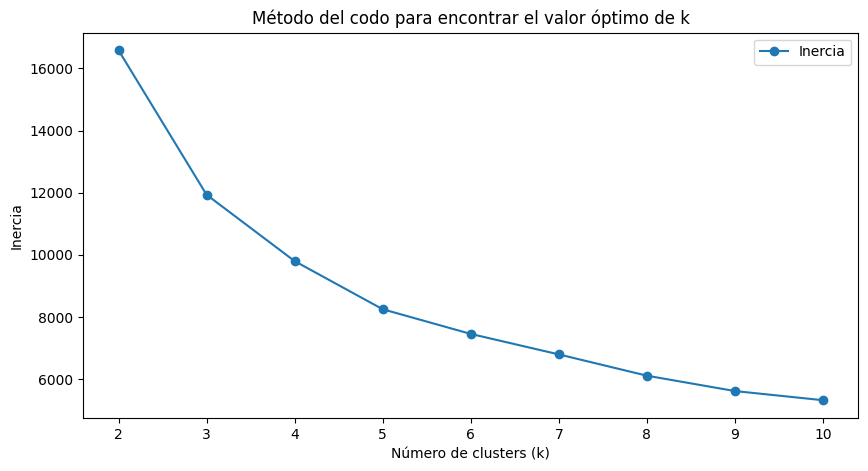

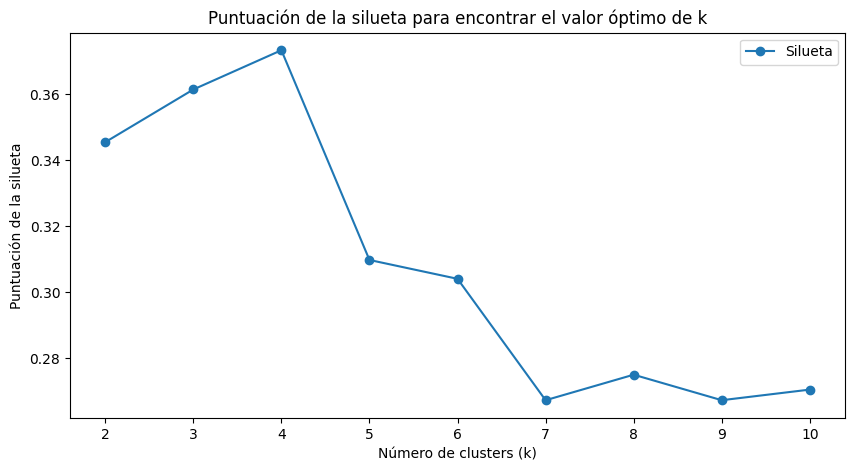

In [58]:
# Calcular la correlación entre todas las variables y la variable objetivo 'quality'
correlaciones = datos.corr()['quality'].sort_values(ascending=False)

# Seleccionar las variables con una correlación significativa (por ejemplo, aquellas con una correlación absoluta mayor que 0.2)
variables_candidatas = correlaciones[abs(correlaciones) > 0.2].index.tolist()

# Excluir 'quality' de las variables candidatas
variables_candidatas.remove('quality')

print("Variables candidatas para el proceso de agrupamiento:", variables_candidatas)

# Seleccionar las variables candidatas del conjunto de datos
variables = datos[variables_candidatas]

# Normalizar los datos
scaler = StandardScaler()
variables_normalizadas = scaler.fit_transform(variables)

# Ejecutar diferentes procesos de agrupamiento con K-Means y encontrar el mejor valor de k
valores_k = range(2, 11)  # Probamos con valores de k de 2 a 10
resultados = []

for k in valores_k:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(variables_normalizadas)
    inercia = kmeans.inertia_
    silueta = silhouette_score(variables_normalizadas, kmeans.labels_)
    resultados.append({'k': k, 'inercia': inercia, 'silueta': silueta})

# Convertir los resultados en un DataFrame para su análisis
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# Graficar la inercia y la puntuación de la silueta en función de k para ayudar a seleccionar el mejor valor de k
plt.figure(figsize=(10, 5))
plt.plot(resultados_df['k'], resultados_df['inercia'], marker='o', label='Inercia')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para encontrar el valor óptimo de k')
plt.xticks(valores_k)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(resultados_df['k'], resultados_df['silueta'], marker='o', label='Silueta')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Puntuación de la silueta')
plt.title('Puntuación de la silueta para encontrar el valor óptimo de k')
plt.xticks(valores_k)
plt.legend()
plt.show()


**Número óptimo de clusters:** El análisis anterior sugiere que el conjunto de datos puede ser mejor agrupado en cuatro clusters distintos. Este hallazgo se basa en la observación del pico más prominente en la gráfica de la puntuación de la silueta, lo que indica que el valor 4 es el más adecuado para la cantidad de clusters.

Por último, vamos a definir una función para calcular la distancia entre los clusters y la variable 'quality' en el contexto de la evaluación de diferentes valores de k en el algoritmo K-Means.

Esta función es una buena opción para elegir el número de clusters por las siguientes razones:

1. La función calcula la distancia entre la media de la variable 'quality' dentro de cada cluster y la media global de 'quality'. Esta distancia refleja cómo están distribuidos los clusters en relación con la variable objetivo 'quality'. Una distancia menor indica que los clusters están más cerca de tener valores de 'quality' similares entre sí y con respecto al promedio global.

2. Como el objetivo del análisis es agrupar datos de manera que los clusters estén estrechamente relacionados con la variable objetivo 'quality', entonces minimizar la distancia entre los clusters y 'quality' es fundamental. Esta función proporciona una métrica específica para evaluar este aspecto y seleccionar el número óptimo de clusters.

    k   silueta  distancia_quality
0   2  0.345411           0.329761
1   3  0.361372           0.323769
2   4  0.373271           0.287801
3   5  0.309709           0.331580
4   6  0.303999           0.299589
5   7  0.267210           0.343225
6   8  0.274944           0.370902
7   9  0.267213           0.366084
8  10  0.270429           0.360203
El mejor valor de k es: 4.0


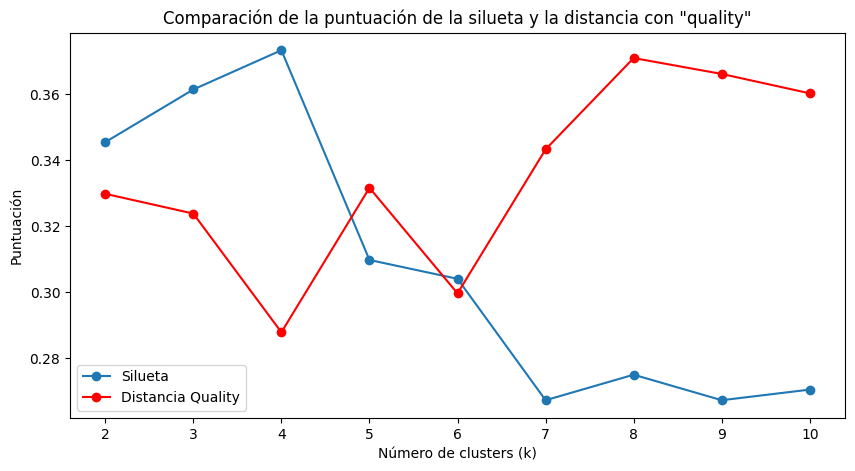

In [59]:
# Definimos una función para calcular la distancia entre los clusters y la variable 'quality'
def distancia_cluster_quality(datos, etiquetas, variable_quality):
    cluster_quality = datos.groupby(etiquetas)[variable_quality].mean()
    return np.abs(cluster_quality - cluster_quality.mean())

# Probamos diferentes valores de k
valores_k = range(2, 11)
resultados_kmeans = []

for k in valores_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    etiquetas = kmeans.fit_predict(variables_normalizadas)

    # Calculamos la distancia entre el cluster y la variable 'quality'
    distancia = distancia_cluster_quality(datos, etiquetas, 'quality')

    # Calculamos la puntuación de la silueta
    silueta = silhouette_score(variables_normalizadas, etiquetas)

    resultados_kmeans.append({'k': k, 'silueta': silueta, 'distancia_quality': distancia.mean()})

# Convertimos los resultados en un DataFrame para su análisis
resultados_kmeans_df = pd.DataFrame(resultados_kmeans)
print(resultados_kmeans_df)

# Seleccionamos el valor de k que maximiza la puntuación de la silueta y minimiza la distancia con 'quality'
mejor_k = resultados_kmeans_df.iloc[resultados_kmeans_df['silueta'].idxmax()]['k']
print("El mejor valor de k es:", mejor_k)

# Visualizamos la comparación entre la puntuación de la silueta y la distancia con 'quality'
plt.figure(figsize=(10, 5))
plt.plot(resultados_kmeans_df['k'], resultados_kmeans_df['silueta'], marker='o', label='Silueta')
plt.plot(resultados_kmeans_df['k'], resultados_kmeans_df['distancia_quality'], marker='o', label='Distancia Quality', color='red')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Puntuación')
plt.title('Comparación de la puntuación de la silueta y la distancia con "quality"')
plt.legend()
plt.xticks(valores_k)
plt.show()


Basándonos en la gráfica anterior, el mejor valor de k sería aquel que maximiza la puntuación de la silueta y minimiza la distancia con respecto a la variable 'quality'. Observando la gráfica de comparación entre la puntuación de la silueta y la distancia con 'quality', podemos ver que hay un punto en k=4 donde la puntuación de la silueta es la más alta y la distancia con 'quality' es la más baja. Este punto representaría el equilibrio óptimo entre la cohesión dentro de los clusters y la separación entre ellos, lo que indica un número adecuado de clusters.


Ahora vamos a analizar los clústers obtenidos para el mejor valor de k.

Se van a calcular las frecuencias de cada categoría de la variable 'quality' original para cada clúster obtenido mediante el algoritmo K-Means, lo que proporcionará una visión de cómo están distribuidos los diferentes niveles de calidad en cada agrupamiento.


In [60]:
# Seleccionar el mejor valor de k
best_k = 4

# Entrenar el modelo K-Means con el mejor valor de k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(variables_normalizadas)  # variables_normalizadas es el conjunto de datos con las características seleccionadas

# Asignar las etiquetas de clúster a cada instancia
cluster_labels = kmeans.labels_

# Agregar las etiquetas de clúster al DataFrame de datos
datos['cluster'] = cluster_labels

# Calcular las frecuencias de cada categoría de 'quality' para cada clúster
cluster_quality_frequencies = datos.groupby(['cluster', 'quality']).size().unstack(fill_value=0)

# Mostrar las frecuencias de cada categoría de 'quality' para cada clúster
print("Frecuencias de cada categoría de 'quality' para cada clúster:")
print(cluster_quality_frequencies)


Frecuencias de cada categoría de 'quality' para cada clúster:
quality  3   4     5     6    7    8  9
cluster                                
0        8  78   637   456   86    2  0
1        8  51   314  1095  732  156  4
2        8  84  1116  1218  256   35  1
3        3   2    61    55    2    0  0


In [61]:
# Contar la cantidad de datos de cada categoría de 'quality'
quality_counts = datos['quality'].value_counts()

# Mostrar los resultados
print("Cantidad de datos de cada categoría de 'quality':")
print(quality_counts)

Cantidad de datos de cada categoría de 'quality':
quality
6    2824
5    2128
7    1076
4     215
8     193
3      27
9       5
Name: count, dtype: int64


Vamos a generar cuatro piecharts, uno por cada clúster, donde cada segmento del gráfico representa la frecuencia de cada categoría de la variable 'quality' dentro de ese clúster. Esta representación es útil para evaluar si existe alguna similitud entre los grupos obtenidos mediante clustering y los valores de la variable 'quality' del conjunto de datos original.

Al observar los piecharts, podemos identificar patrones en la distribución de las categorías de 'quality' dentro de cada clúster. Si los clústeres muestran distribuciones de 'quality' similares entre sí, con proporciones de categorías de 'quality' similares en cada clúster, podríamos inferir que existe cierta relación entre la segmentación realizada por el algoritmo de clustering y los valores de 'quality' en el dataset original.

Por otro lado, si los clústeres presentan distribuciones de 'quality' muy diferentes entre sí, con algunas categorías de 'quality' dominando en ciertos clústeres y otras en los restantes, podría indicar que el algoritmo de clustering ha identificado grupos con diferentes perfiles de 'quality'.


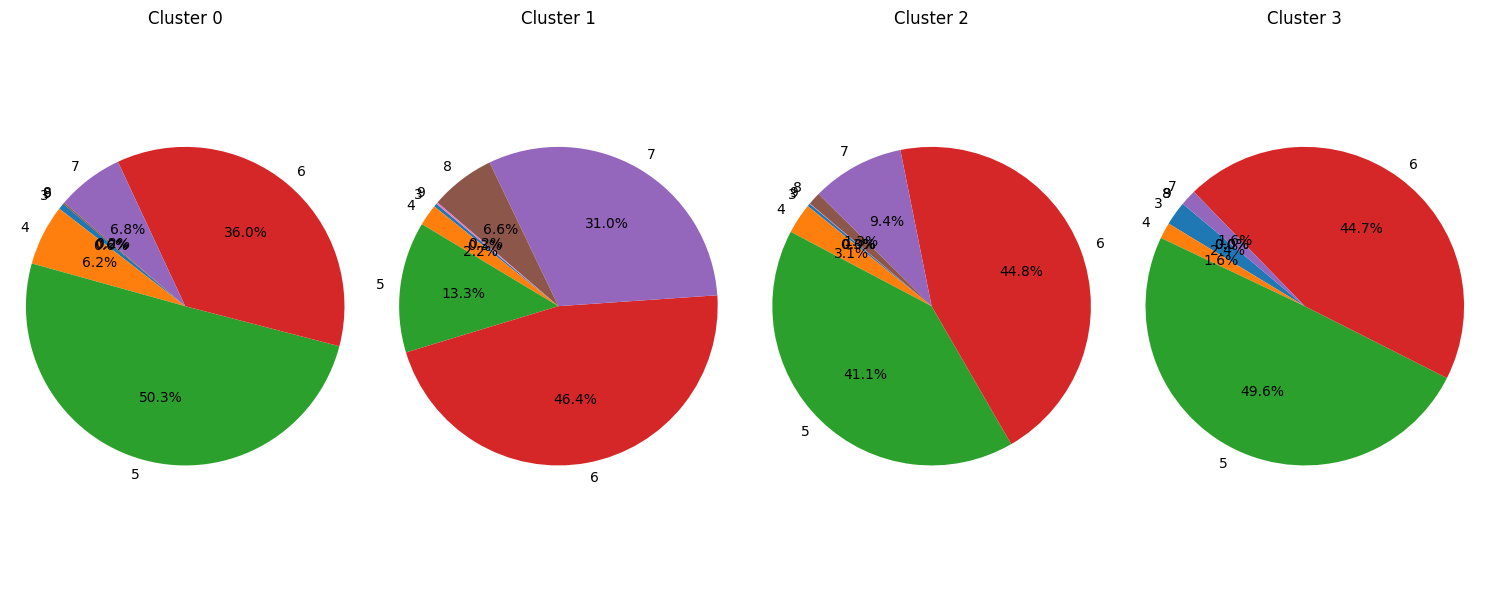

In [62]:
# Obtener la cantidad de clústeres
num_clusters = len(cluster_quality_frequencies.index)

# Definir el tamaño de la figura
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 6))

# Generar pie charts para cada clúster
for i, cluster in enumerate(cluster_quality_frequencies.index):
    # Obtener las frecuencias de 'quality' para el clúster actual
    frequencies = cluster_quality_frequencies.loc[cluster]

    # Crear el pie chart
    axs[i].pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(f'Cluster {cluster}')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()


Los resultados del proceso de clustering muestran que la distribución de las categorías de 'quality' varía considerablemente entre los diferentes grupos. Por ejemplo, en el clúster 1 hay muchas más instancias de la categoría '7' en comparación con los otros clústeres. Además, en este mismo clúster, la categoría '8' aparece más frecuentemente que en los otros grupos y la categoría '5' pierde mucha relevancia.

Por otro lado, el clúster 0 es el que tiene más instancias de las categorías '5' y '4' en comparación con los otros grupos.

También es interesante notar que el clúster 3 tiene la mayor frecuencia de la categoría '3' en comparación con los otros clústeres.

Una cosa importante a considerar es que la predominancia de las categorías '5' y '6' en la mayoría de los clústeres podría deberse al hecho de que estas categorías son las más comunes en la base de datos en general. Esto se debe a que la variable 'quality' no está distribuida equitativamente en el conjunto de datos original.



A continuación, se realiza una evaluación del desempeño del algoritmo de clustering K-Means en relación con la variable objetivo 'quality'. Se va a generar una matriz que muestra la frecuencia con la que las instancias pertenecientes a cada categoría de 'quality' se agrupan en cada clúster. Esto permite evaluar cómo se alinean las etiquetas de K-Means con los valores reales de 'quality'.

Por último, se calcula la precisión del agrupamiento dividiendo la suma de los valores diagonales de la matriz de confusión (que representan las instancias correctamente clasificadas) entre el total de instancias. Esta métrica proporciona una medida de cuán bien el algoritmo de clustering ha agrupado las instancias en relación con la variable 'quality'.


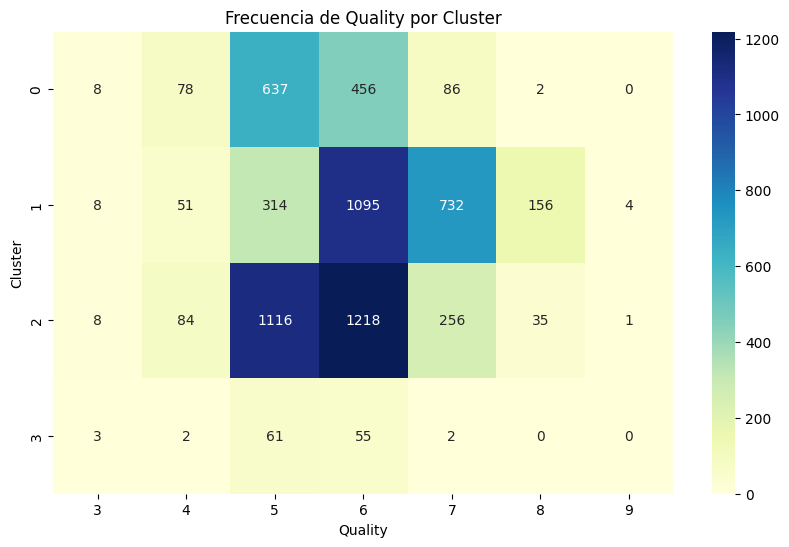

Precisión del agrupamiento: 0.1901669758812616


In [63]:
# Obtener el mejor valor de k como un entero
mejor_k = int(resultados_kmeans_df.iloc[resultados_kmeans_df['silueta'].idxmax()]['k'])

# Crear y ajustar el modelo KMeans con el mejor valor de k
kmeans = KMeans(n_clusters=mejor_k, random_state=42)
etiquetas = kmeans.fit_predict(variables_normalizadas)

# Calcular las frecuencias de 'quality' por clúster
frecuencias_quality_por_cluster = pd.crosstab(index=etiquetas, columns=datos['quality'])

# Visualizar las frecuencias de 'quality' por clúster
plt.figure(figsize=(10, 6))
sns.heatmap(frecuencias_quality_por_cluster, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel('Quality')
plt.ylabel('Cluster')
plt.title('Frecuencia de Quality por Cluster')
plt.show()

# Calcular la suma total de instancias correctamente agrupadas en cada clúster
sum_correctas_por_cluster = np.diag(frecuencias_quality_por_cluster).sum()

# Calcular la precisión del agrupamiento
precision_agrupamiento = sum_correctas_por_cluster / len(datos)

print("Precisión del agrupamiento:", precision_agrupamiento)

Se ha obtenido una precisión del 19%, lo que significa que la empresa que analiza la calidad de los diferentes vinos no está realizando su trabajo adecuadamente.

Aplicamos PCA para reducir la dimensionalidad de los datos a tres dimensiones y facilitar así su visualización. Esto nos permite comprender mejor la estructura de los datos y facilita la interpretación de los resultados del clustering en un espacio tridimensional más accesible y comprensible.

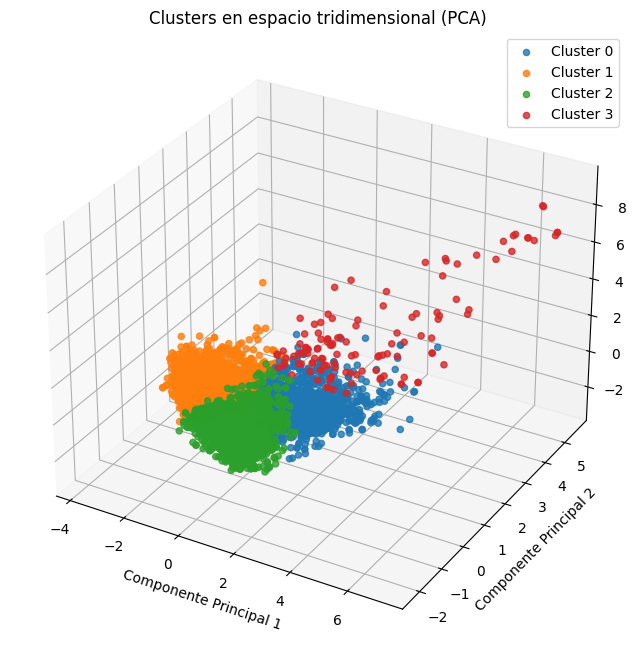

In [64]:
from sklearn.decomposition import PCA

# Reducir la dimensionalidad de los datos a tres dimensiones utilizando PCA
pca = PCA(n_components=3)
variables_reducidas = pca.fit_transform(variables_normalizadas)

# Crear una figura y un eje tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos de datos con colores según los clusters
for cluster in range(mejor_k):
    ax.scatter(variables_reducidas[etiquetas == cluster, 0],
               variables_reducidas[etiquetas == cluster, 1],
               variables_reducidas[etiquetas == cluster, 2],
               label=f'Cluster {cluster}', alpha=0.8)

# Añadir etiquetas y leyenda
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Clusters en espacio tridimensional (PCA)')
ax.legend()

# Mostrar el gráfico
plt.show()


Vamos a realizar una visualización de las proyecciones bidimensionales de los datos en tres planos principales para ayudar a comprender la distribución y la estructura de los datos en un espacio tridimensional.

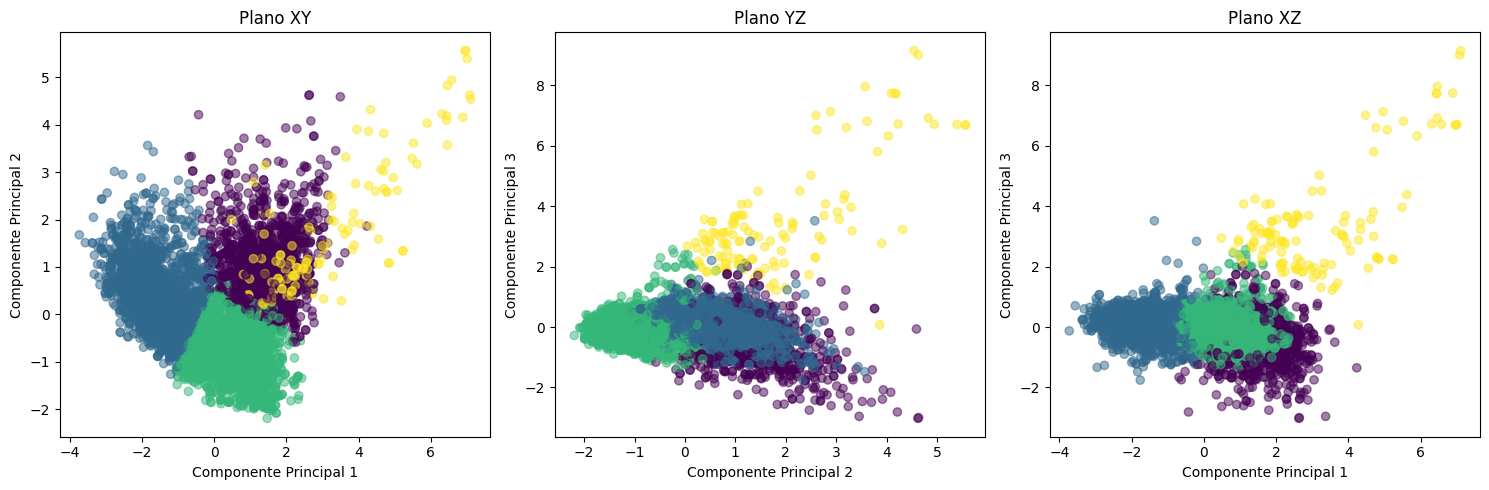

In [65]:
# Extraer las coordenadas de los componentes principales
x = variables_reducidas[:, 0]
y = variables_reducidas[:, 1]
z = variables_reducidas[:, 2]

# Crear subgráficos 2D para cada plano
plt.figure(figsize=(15, 5))

# Plano XY
plt.subplot(131)
plt.scatter(x, y, c=etiquetas, cmap='viridis', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Plano XY')

# Plano YZ
plt.subplot(132)
plt.scatter(y, z, c=etiquetas, cmap='viridis', alpha=0.5)
plt.xlabel('Componente Principal 2')
plt.ylabel('Componente Principal 3')
plt.title('Plano YZ')

# Plano XZ
plt.subplot(133)
plt.scatter(x, z, c=etiquetas, cmap='viridis', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 3')
plt.title('Plano XZ')

plt.tight_layout()
plt.show()


Ahora se va a visualizar y comparar las características promedio de cada cluster en el conjunto de datos mediante gráficos de radar. Estos gráficos ofrecen una representación visual intuitiva de cómo se distribuyen las variables seleccionadas entre los diferentes clusters, permitiendo una interpretación rápida y eficaz de las diferencias entre ellos.

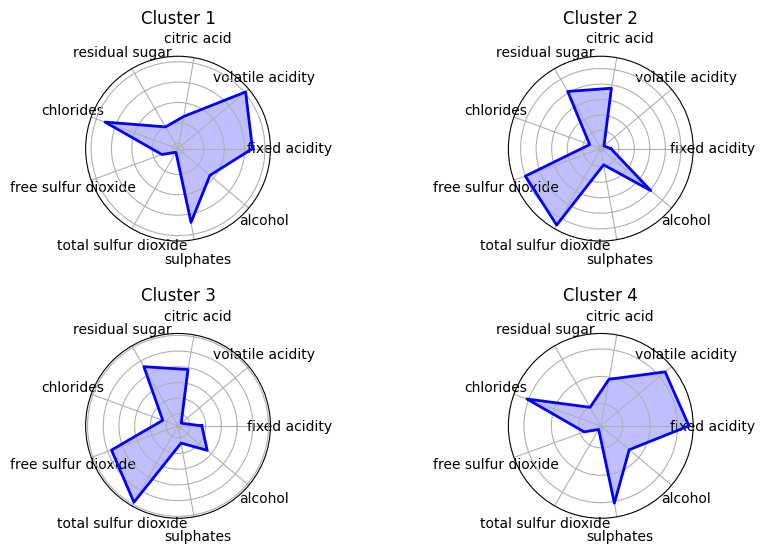

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Lista de variables que quieres incluir en los gráficos de araña
variables_seleccionadas = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']

# Crear un DataFrame con las variables seleccionadas y las etiquetas de los clusters
datos_seleccionados = datos[variables_seleccionadas]
datos_seleccionados['cluster'] = etiquetas  # etiquetas obtenidas del clustering

# Estandarizar los datos seleccionados
scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(datos_seleccionados.drop('cluster', axis=1))
datos_estandarizados = pd.DataFrame(datos_estandarizados, columns=variables_seleccionadas)
datos_estandarizados['cluster'] = datos_seleccionados['cluster']

# Obtener el número de clusters
num_clusters = datos_seleccionados['cluster'].nunique()

# Definir la cantidad de filas y columnas para los subplots
num_rows = (num_clusters + 1) // 2
num_cols = 2

# Crear la figura y los subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6), subplot_kw=dict(polar=True))

# Ajustar la posición de los subplots para que se vean bien
plt.subplots_adjust(hspace=0.5)

# Crear un gráfico de araña para cada cluster
for cluster_num, ax in zip(range(num_clusters), axs.flatten()):
    cluster_data = datos_estandarizados[datos_estandarizados['cluster'] == cluster_num].drop('cluster', axis=1)
    cluster_means = cluster_data.mean()

    values = cluster_means.values
    num_vars = len(values)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables_seleccionadas)

    ax.set_title(f'Cluster {cluster_num + 1}')

# Ocultar subplots no utilizados
for i in range(num_clusters, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.show()


Vemos que los clústers 1 y 4 se parecen un poco y los clústers 2 y 3 también.

Para comprender las diferencias entre los clústers en función de las variables presentes en el conjunto de datos, también se va a proporcionar una visión general de la distribución de las variables dentro de cada clúster.


In [67]:
# Analizar la distribución de las variables dentro de cada clúster
variables_por_cluster = datos.groupby('cluster').mean()
print("Distribución de las variables por clúster:")
print(variables_por_cluster)

Distribución de las variables por clúster:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0             8.092186          0.590987     0.232983        3.110852   
1             6.797564          0.282303     0.324602        3.483347   
2             7.126600          0.266751     0.346545        8.269297   
3             7.614634          0.419309     0.436667        3.799593   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0         0.081125            17.436464             59.284925  0.996851   
1         0.039122            29.695975            111.574153  0.991691   
2         0.050761            37.384658            146.287344  0.996187   
3         0.221455            29.626016            101.544715  0.995980   

               pH  sulphates   quality  wine type    alcohol  
clus

**Interpretación de los clústers**:

Dentro del **Cluster 0**, observamos una tendencia hacia vinos con una marcada acidez, como lo sugieren los niveles elevados de 'volatile acidity' y 'fixed acidity'. Esta combinación puede conferir a estos vinos un carácter más intenso.Sin embargo, es importante destacar los bajos niveles de 'free sulfur dioxide', 'total sulfur dioxide' y 'citric acid' en este grupo. La escasez de estos compuestos antioxidantes y ácido cítrico puede resultar en vinos que carecen de la frescura y estabilidad que a menudo se asocian con la calidad. Esto sugiere que los vinos en este cluster pueden ser más propensos a la oxidación prematura y tener una vida útil más corta en comparación con otros grupos.

Por otro lado, el **Cluster 1** exhibe una distribución de características que sugiere vinos con un equilibrio notable entre acidez, cuerpo y contenido alcohólico. Los bajos niveles de 'chlorides', 'fixed acidity' y 'sulphates' indican una menor presencia de compuestos que podrían contribuir a la astringencia y al sabor mineral. En cambio, el alto contenido de alcohol puede proporcionar una sensación de plenitud en boca y un final cálido y persistente. Esta combinación de características podría hacer que estos vinos sean particularmente atractivos para aquellos que buscan vinos bien equilibrados y de alta calidad.

El **Cluster 2** presenta una interesante combinación de características que sugiere vinos con un perfil más suave y dulce. La baja 'volatile acidity' indica una acidez más moderada, mientras que los altos niveles de 'residual sugar' sugieren un contenido de azúcar más elevado. Esta combinación puede resultar en vinos con un sabor más dulce, que pueden ser particularmente atractivos para aquellos con preferencia por vinos menos ácidos. Además, los altos niveles de 'free sulfur dioxide' y 'total sulfur dioxide' pueden proporcionar una mayor capacidad de envejecimiento y una mejor conservación del vino.

Finalmente, el **Cluster 3** exhibe una distribución de características que sugiere vinos con una frescura y vitalidad distintivas. El alto contenido de 'citric acid' puede aportar una acidez refrescante y cítrica. Además, los altos niveles de 'chlorides' y 'sulphates' pueden contribuir a la estructura y complejidad del sabor, agregando matices salinos y minerales al vino. Sin embargo, el bajo contenido de alcohol puede hacer que estos vinos sean más ligeros en cuerpo y menos cálidos en boca, lo que podría ser preferido por aquellos que buscan opciones más refrescantes y de menor graduación alcohólica.


## Ejercicio 4:

La empresa productora de vinos desea mejorar el proceso de producción de sus vinos con el objetivo de
mejorar las futuras producciones.
Para ello han pensado en utilizar un algoritmo de agrupamiento jerárquico para segmentar los diferentes vinos
en base a sus componentes, calidad y nivel de alcohol.

Para seleccionar los 10 ejemplos más significativos se puede usar la distancia euclidea de cada elemento dentro del clúster al centroide. De esta manera, se pueden ordenar los resultados obtenidos en cada clúster y seleccionar los 10 más cercanos. Estos serán los que mejor representan a cada clúster, dado que al estar todos más cerca del centroide crearán un grupo más homogeneo y sin outiliers.

En primer lugar, se muestran los centroides de cada clúster. Una vez se tienen estos, se calcula la distancia de cada punto a su centroide, esto se realiza para los 4 clústeres. Después, se cogen las 10 distancias más pequeñas de cada clúster y se crea el nuevo dataset con ellas.  

In [69]:
centroides = kmeans.cluster_centers_
print("Centroides de cada clúster:")
print(centroides)


Centroides de cada clúster:
[[-0.25908491  0.76487844  1.54278666  0.74497283]
 [ 0.99682877 -0.49869936 -0.34578952 -1.01921011]
 [-0.70770857 -0.14872142 -0.44047062  0.51755208]
 [-0.8150798   4.983479    0.4921543   0.44696055]]


In [71]:
# Calcular la distancia de cada punto de cada clúster a su centroide
distancias_cluster_0 = np.linalg.norm(variables_normalizadas[kmeans.labels_ == 0] - centroides[0], axis=1)
distancias_cluster_1 = np.linalg.norm(variables_normalizadas[kmeans.labels_ == 1] - centroides[1], axis=1)
distancias_cluster_2 = np.linalg.norm(variables_normalizadas[kmeans.labels_ == 2] - centroides[2], axis=1)
distancias_cluster_3 = np.linalg.norm(variables_normalizadas[kmeans.labels_ == 3] - centroides[3], axis=1)


# Obtener los índices de las 10 mejores muestras de cada clúster
indices_mejores_cluster_0 = np.argsort(distancias_cluster_0)[:10]
indices_mejores_cluster_1 = np.argsort(distancias_cluster_1)[:10]
indices_mejores_cluster_2 = np.argsort(distancias_cluster_2)[:10]
indices_mejores_cluster_3 = np.argsort(distancias_cluster_3)[:10]

# Obtener las 10 mejores muestras de cada clúster
mejores_muestras_cluster_0 = variables_normalizadas[kmeans.labels_ == 0][indices_mejores_cluster_0]
mejores_muestras_cluster_1 = variables_normalizadas[kmeans.labels_ == 1][indices_mejores_cluster_1]
mejores_muestras_cluster_2 = variables_normalizadas[kmeans.labels_ == 2][indices_mejores_cluster_2]
mejores_muestras_cluster_3 = variables_normalizadas[kmeans.labels_ == 3][indices_mejores_cluster_3]

# Imprimir las 10 mejores muestras de cada clúster
print("Las 10 mejores muestras del clúster 0:")
print(mejores_muestras_cluster_0)
print("\nLas 10 mejores muestras del clúster 1:")
print(mejores_muestras_cluster_1)
print("\nLas 10 mejores muestras del clúster 2:")
print(mejores_muestras_cluster_2)
print("\nLas 10 mejores muestras del clúster 3:")
print(mejores_muestras_cluster_3)


Las 10 mejores muestras del clúster 0:
[[-0.32855237  0.70030368  1.59728092  0.78542496]
 [-0.24462127  0.82057091  1.59728092  0.65892816]
 [-0.24462127  0.85063771  1.65844204  0.86405811]
 [-0.24462127  0.70030368  1.35263647  0.68969765]
 [-0.24462127  0.54996966  1.4749587   0.72730481]
 [-0.24462127  0.82057091  1.65844204  0.55636319]
 [-0.41248347  0.85063771  1.35263647  0.72730481]
 [-0.41248347  0.61010327  1.53611981  0.96662308]
 [-0.49641457  0.73037049  1.59728092  0.52901253]
 [-0.49641457  0.73037049  1.59728092  0.52901253]]

Las 10 mejores muestras del clúster 1:
[[ 1.01434524 -0.59256895 -0.35987472 -0.98211143]
 [ 1.01434524 -0.53243534 -0.35987472 -0.91373478]
 [ 0.93041414 -0.47230173 -0.35987472 -1.18724138]
 [ 0.93041414 -0.53243534 -0.35987472 -1.18724138]
 [ 0.93041414 -0.53243534 -0.35987472 -1.18724138]
 [ 0.93041414 -0.53243534 -0.35987472 -1.18724138]
 [ 0.93041414 -0.38210131 -0.48219694 -0.98211143]
 [ 0.93041414 -0.59256895 -0.2987136  -1.19066021]
 [

Nuevo dataset con las características más representativas de cada clúster:

In [73]:
df_cluster_0 = pd.DataFrame(variables_normalizadas[kmeans.labels_ == 0][indices_mejores_cluster_0])
df_cluster_1 = pd.DataFrame(variables_normalizadas[kmeans.labels_ == 1][indices_mejores_cluster_1])
df_cluster_2 = pd.DataFrame(variables_normalizadas[kmeans.labels_ == 2][indices_mejores_cluster_2])
df_cluster_3 = pd.DataFrame(variables_normalizadas[kmeans.labels_ == 3][indices_mejores_cluster_3])

# Concatenar los DataFrames en uno solo
mejores_muestras_df = pd.concat([df_cluster_0, df_cluster_1, df_cluster_2, df_cluster_3], axis=1)
print(mejores_muestras_df.head())

          0         1         2         3         0         1         2  \
0 -0.328552  0.700304  1.597281  0.785425  1.014345 -0.592569 -0.359875   
1 -0.244621  0.820571  1.597281  0.658928  1.014345 -0.532435 -0.359875   
2 -0.244621  0.850638  1.658442  0.864058  0.930414 -0.472302 -0.359875   
3 -0.244621  0.700304  1.352636  0.689698  0.930414 -0.532435 -0.359875   
4 -0.244621  0.549970  1.474959  0.727305  0.930414 -0.532435 -0.359875   

          3         0         1         2         3         0         1  \
0 -0.982111 -0.664277 -0.141567 -0.482197  0.453798 -1.000001  5.420792   
1 -0.913735 -0.664277 -0.141567 -0.482197  0.453798 -0.832139  4.999857   
2 -1.187241 -0.664277 -0.231767 -0.482197  0.474311 -0.832139  4.849523   
3 -1.187241 -0.748208 -0.201700 -0.543358  0.624740 -1.000001  4.699189   
4 -1.187241 -0.748208 -0.201700 -0.543358  0.624740 -0.916070  4.608988   

          2         3  
0  0.924509  0.727305  
1  0.924509  1.137565  
2  0.312898 -0.366722  
3 

Ahora se utilizará un algoritmo de agrupamiento jerárquico, como puede ser el clúster jerárquico aglomerativo. Se comienza con que cada punto es un clúster. En cada paso, se mezclan los pares de clústeres más cercanos entre sí en un único elemento. Este proceso es iterativo y finaliza con todos los elementos en un único clúster. Sirve para evaluar cómo serían los clústers en funcón de la k que se eligiera.

Para empezar, se realizará un dendrograma donde se podrán ver las distancias entre los posibles clústers desde que son tantos puntos como clústers hasta que se convierte en uno único con todos los puntos y así saber cuál es el número óptimo de ellos.

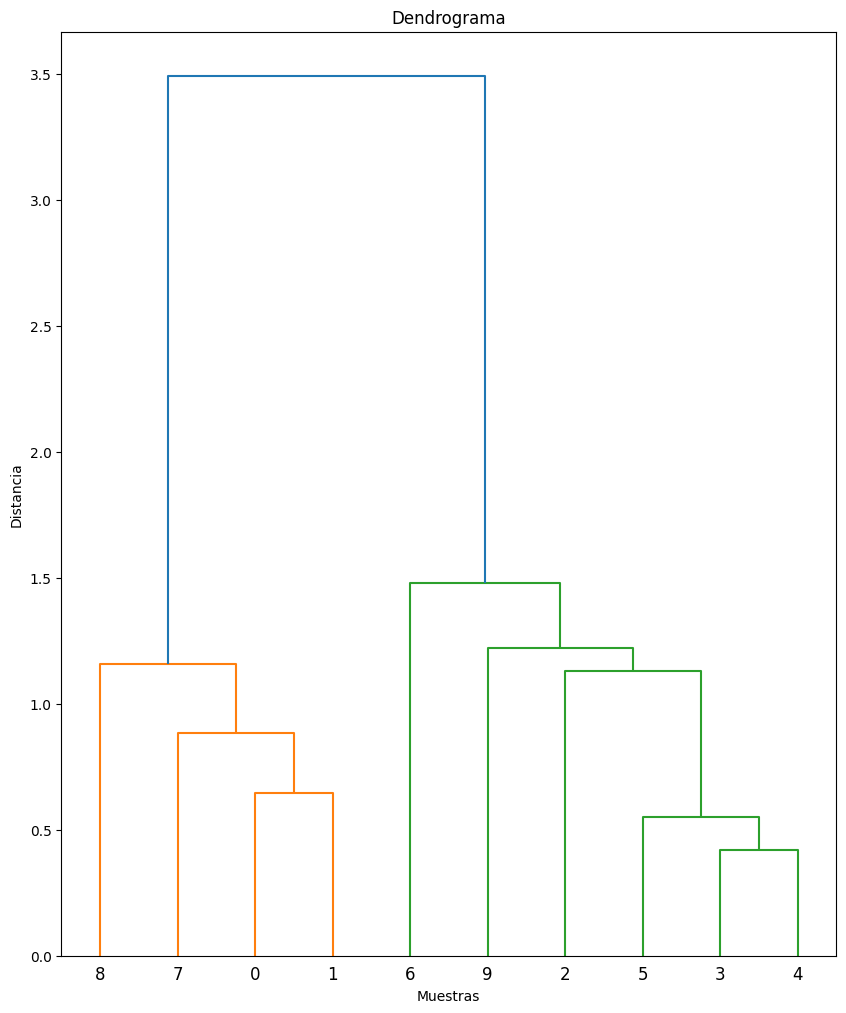

In [77]:
# Calcular la matriz de enlace
enlace = hierarchy.linkage(mejores_muestras_df, method='ward')

# Plotear el dendrograma
plt.figure(figsize=(10, 12))
dendrogram = hierarchy.dendrogram(enlace)
plt.title('Dendrograma')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()



En el dendrograma se muestran los posibles clústers que podrían realizarse en función de las distancias entre cada uno de ellos. Se puede comprobar que usando únicamente los puntos más cercanos al centroide en vez de salir como número óptimo de clústers 4 se podrían usar 3. Ya que, a una distancia de aproximadamente 1.2 habría un clúster formado por las muestras 8, 7, 0 y 1, otro formado por la muestra 6 y otro formado por las muestras 9, 2, 5, 3 y 4. Esta sería una combinación óptima, pero no es la única.

Como segunda opción se podrían usar dos clústers usando las muestras representadas en naranja como clúster 0 y las representadas en verde como clúster 1.
